In [ ]:
##############################################################################################
#                              MetaClassifier.ipynb
##############################################################################################
# Purpose: An attempt at creating a meta-classifier to combine User and DNN outputs
# Usage: Run cells as needed
# Author: Alexandros Pratsos
# Date: 08/01/24
##############################################################################################

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier


df = pd.read_csv('ntn_data_6-24-24_retirement=20.csv')
#df.head()

In [3]:
#This cell obtains the X, Y data used to train all the models
#X data: dnn skim confidence, dnn cascade confidence, dnn through-going confidence, dnn start-track confidence, dnn stopping-track confidence, user vote, user agreement
#Y data: new MC truth value

def get_classifications_ML(df: pd.DataFrame, dnn_threshold_bottom: float, dnn_threshold_top: float, user_threshold_agreement=.55):
    X = []
    Y = []
    #categories = [2, 3, 4]
    for i in range(len(df['new_truth_classification'])):
        dnn_skim        = df['pred_skim'][i]
        dnn_cascade     = df['pred_cascade'][i]
        dnn_tgtrack     = df['pred_tgtrack'][i]
        dnn_starttracks = df['pred_starttracks'][i]
        dnn_stoptrack   = df['pred_stoptrack'][i]        
        #dnn_conf = max(df['pred_skim'][i], df['pred_cascade'][i], df['pred_tgtrack'][i], df['pred_starttracks'][i], df['pred_stoptrack'][i])
        
        user = df['user_classification'][i]
        user_conf = df['user agreement'][i]
        val = df['new_truth_classification'][i]

        #if dnn_conf >= dnn_threshold_bottom and dnn_conf <= dnn_threshold_top and user_conf >= user_threshold_agreement:
        X.append([dnn_skim, dnn_cascade, dnn_tgtrack, dnn_starttracks, dnn_stoptrack, user, user_conf])
        Y.append(val)
    return X, Y

X, Y = get_classifications_ML(df, 0, 1, 0)

print("# of classifications:", len(X))


# user_class = [row[0] for row in classifications]
# dnn_class = [row[1] for row in classifications]
# mc_class = [row[2] for row in classifications]
# dnn_conf = [row[3] for row in classifications]
# user_conf = [row[4] for row in classifications]

# of classifications: 4271


In [162]:
tot_score = 0
trials = 100
for i in range(trials):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
    
    clf = DecisionTreeClassifier(max_depth = 100, max_leaf_nodes = 20)
    clf.fit(X_train, Y_train)
    
    tot_score += clf.score(X_test, Y_test)
print('average_score was: ', tot_score/trials)

average_score was:  0.8700468164794003


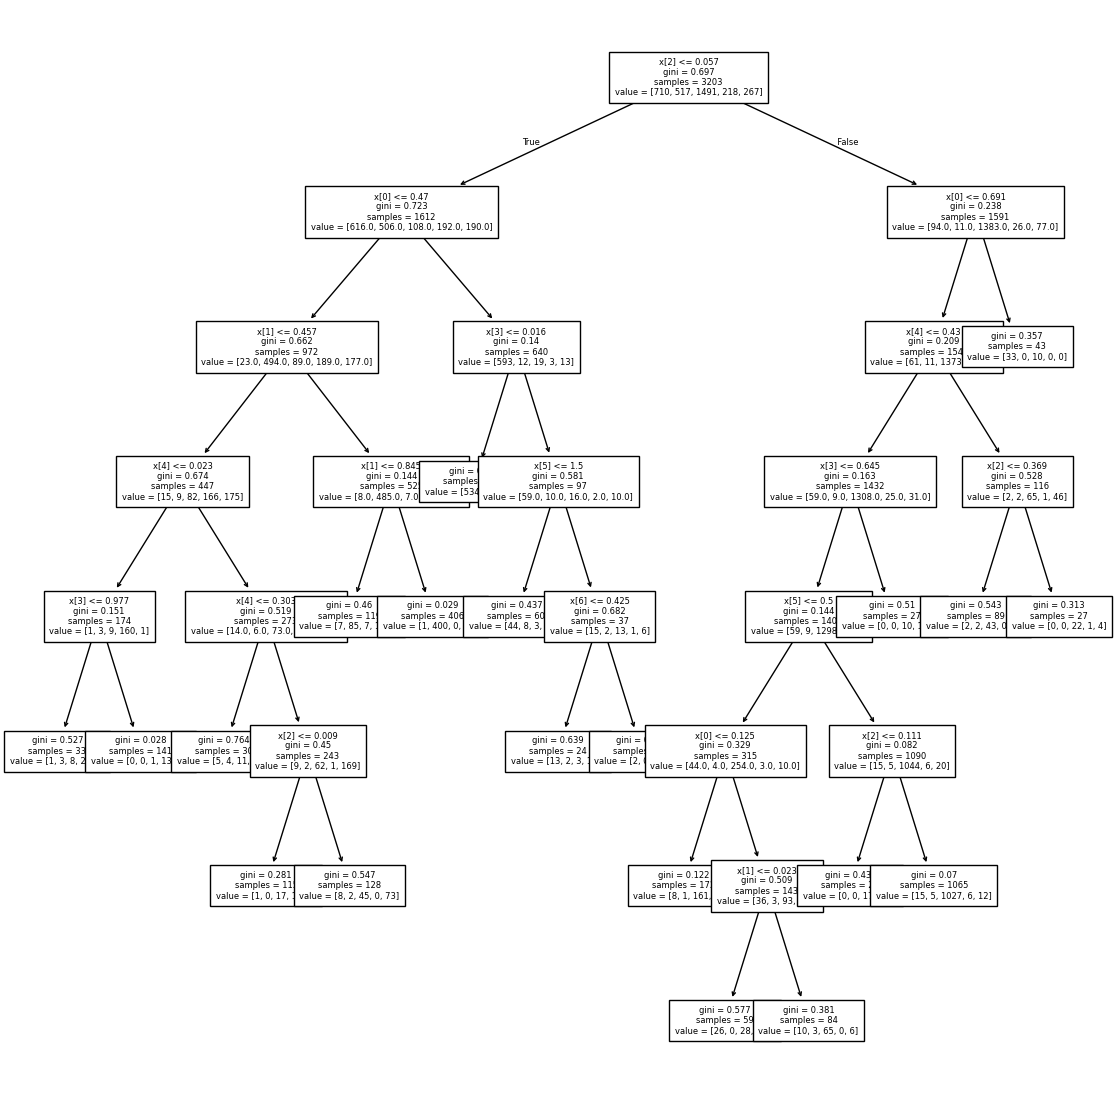

In [93]:
plt.figure(figsize=(14,14))
tree.plot_tree(clf, fontsize=6)
plt.show()
#plt.savefig('tree_diagram.png', bbox_inches='tight')
#plt.savefig('tree_diagram.png', dpi=100)

In [90]:
print(clf.feature_importances_)

[0.28466796 0.1665359  0.41428503 0.02215558 0.10089923 0.00851528
 0.00294103]


In [92]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 100,
 'max_features': None,
 'max_leaf_nodes': 20,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [186]:
tree_para = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90], 'max_leaf_nodes': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}
clf = GridSearchCV(DecisionTreeClassifier(), tree_para, scoring = make_scorer(f1_score, average = 'micro'), cv=5)
clf.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90],
                         'max_leaf_nodes': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                            14, 15]},
             scoring=make_scorer(f1_score, response_method='predict', average=micro))

In [108]:
clf.score(X_train, Y_train)

0.8816734311582891

In [187]:
best_tree = clf.best_estimator_

In [191]:
best_tree.score(X_test, Y_test)

0.8679775280898876

In [189]:
print(best_tree.feature_importances_)

[0.2968396  0.17526978 0.43408874 0.         0.09380188 0.
 0.        ]


In [ ]:
plt.figure(figsize=(20,20))
tree.plot_tree(best_tree, fontsize=8)
#plt.show()
plt.savefig('best_tree_diagram.png', dpi=100)

In [120]:
best_tree.get_n_leaves()

10

In [134]:
tot_score = 0
trials = 100
for i in range(trials):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
    tot_score += best_tree.score(X_test, Y_test)
print('average score on', trials, 'trials was: ', np.round(tot_score/trials, 3))
print('Feature importances are        : ', np.round(best_tree.feature_importances_, 3))
print('Depth of the tree is           : ', best_tree.get_depth())
print('Number of leaves is            : ', best_tree.get_n_leaves())

average score on 100 trials was:  0.883
Feature importances are        :  [0.29  0.163 0.421 0.02  0.099 0.006 0.   ]
Depth of the tree is           :  5
Number of leaves is            :  10


In [143]:
def get_classifications_ML_simple(df: pd.DataFrame, dnn_threshold_bottom: float, dnn_threshold_top: float, user_threshold_agreement=.55):
    X = []
    Y = []
    #categories = [2, 3, 4]
    for i in range(len(df['new_truth_classification'])):
        dnn_skim        = df['pred_skim'][i]
        dnn_cascade     = df['pred_cascade'][i]
        dnn_tgtrack     = df['pred_tgtrack'][i]
        dnn_starttracks = df['pred_starttracks'][i]
        dnn_stoptrack   = df['pred_stoptrack'][i]    
        dnn = df['dnn_classification'][i]
        dnn_conf = max(dnn_skim, dnn_cascade, dnn_tgtrack, dnn_starttracks, dnn_stoptrack)
        
        user = df['user_classification'][i]
        user_conf = df['user agreement'][i]
        val = df['new_truth_classification'][i]

        #if dnn_conf >= dnn_threshold_bottom and dnn_conf <= dnn_threshold_top and user_conf >= user_threshold_agreement:
        X.append([dnn, dnn_conf, user, user_conf])
        Y.append(val)
    return X, Y

X_simple, Y_simple = get_classifications_ML_simple(df, 0, 1, 0)

print("# of classifications:", len(x_data))

# of classifications: 4271


In [163]:
X_train_simple, X_test_simple, Y_train_simple, Y_test_simple = train_test_split(X_simple, Y_simple)

clf_simple = DecisionTreeClassifier(max_depth = 100, max_leaf_nodes = 20)
clf_simple.fit(X_train_simple, Y_train_simple)

DecisionTreeClassifier(max_depth=100, max_leaf_nodes=20)

In [164]:
clf_simple.score(X_test_simple, Y_test_simple)

0.8651685393258427

In [165]:
tree_para = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90], 'max_leaf_nodes': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}
clf_simple = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5)
clf_simple.fit(X_train_simple, Y_train_simple)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90],
                         'max_leaf_nodes': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                            14, 15]})

In [149]:
best_tree_simple = clf_simple.best_estimator_

In [166]:
best_tree_simple.score(X_test_simple, Y_test_simple)

0.8689138576779026

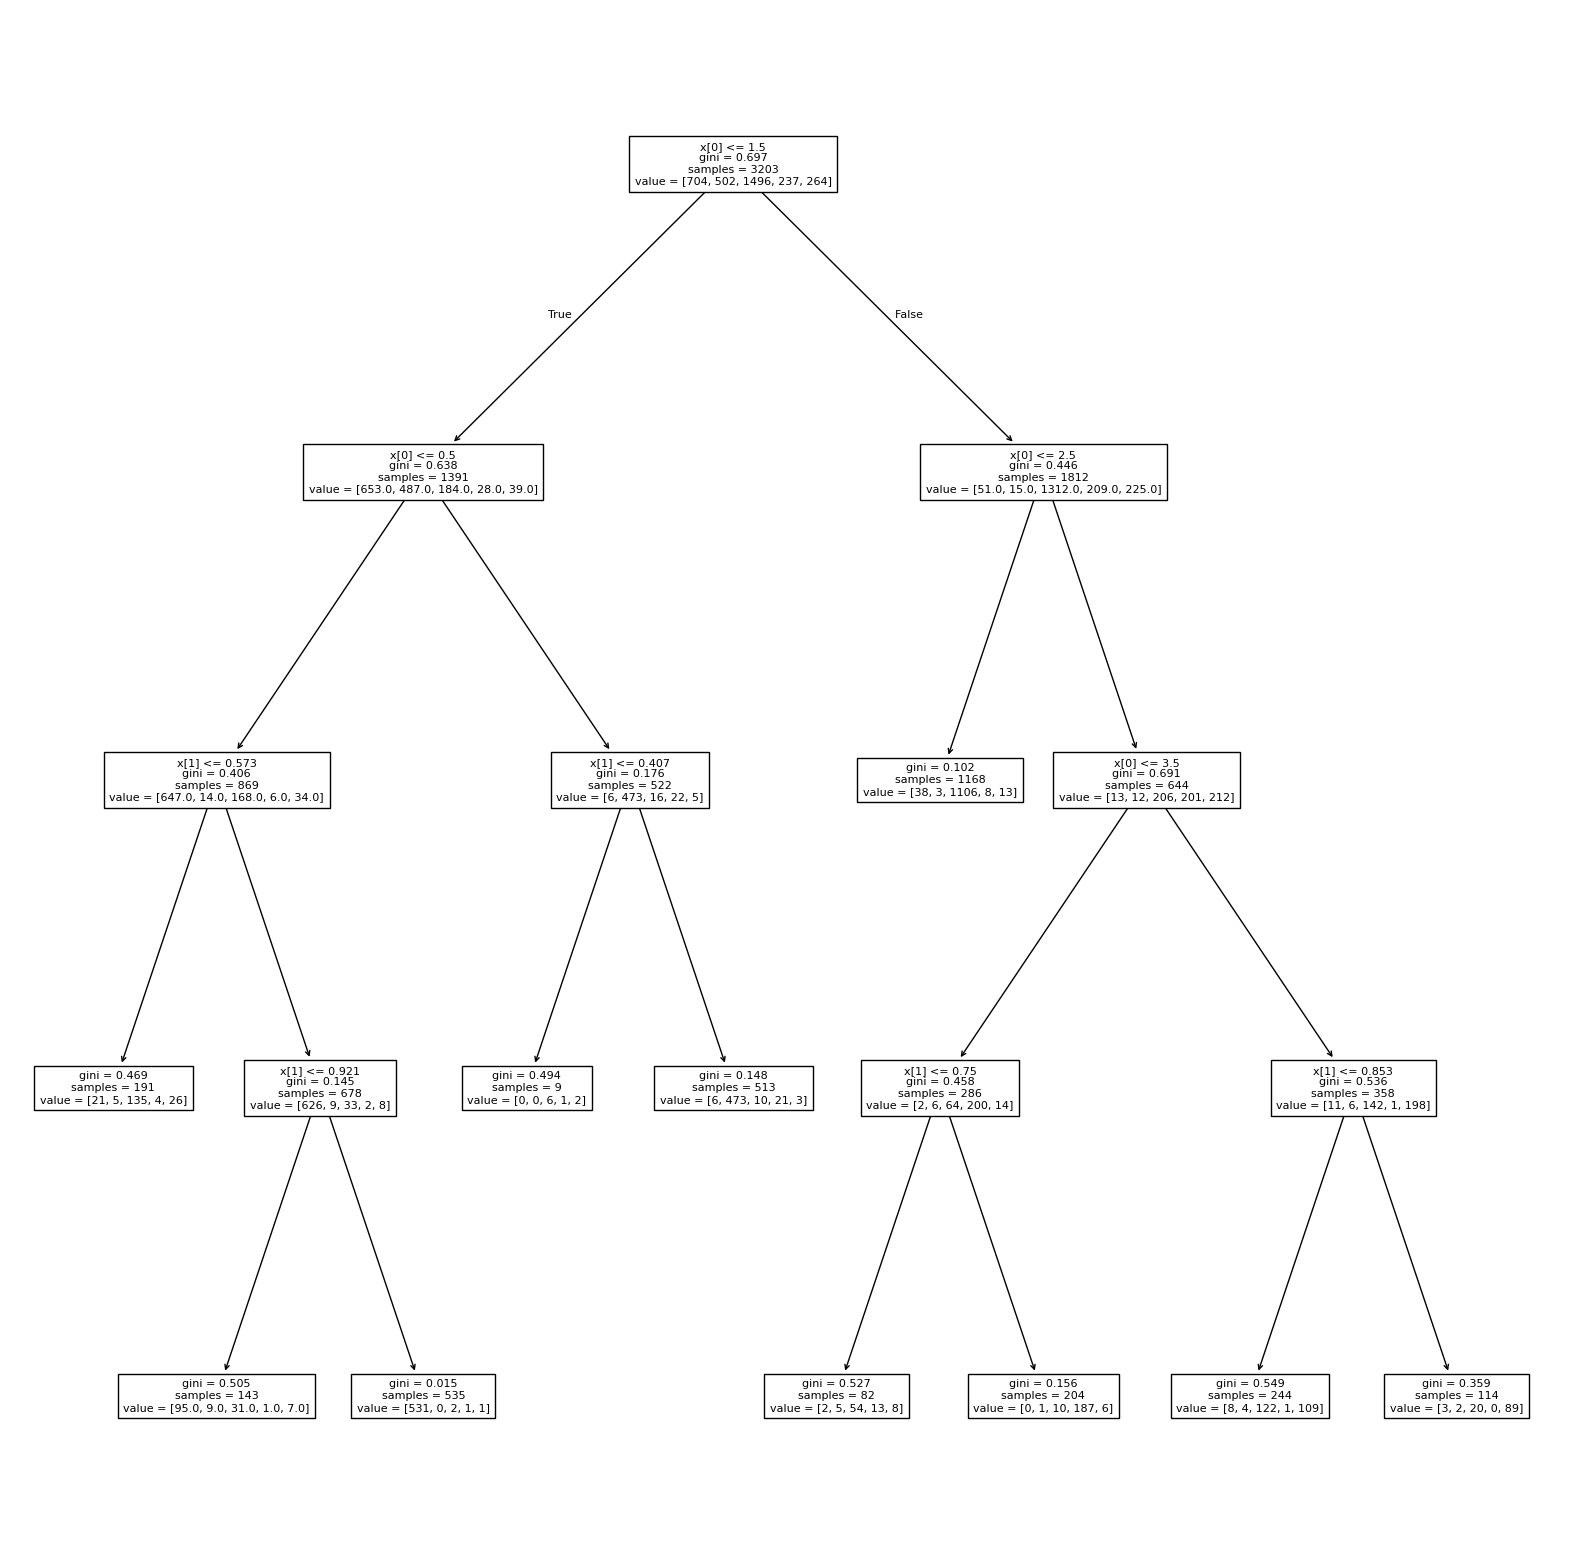

In [167]:
plt.figure(figsize=(20,20))
tree.plot_tree(best_tree_simple, fontsize=8)
plt.show()
#plt.savefig('best_tree_diagram.png', dpi=100)

In [168]:
tot_score = 0
trials = 100
for i in range(trials):
    X_train_simple, X_test_simple, Y_train_simple, Y_test_simple = train_test_split(X_simple, Y_simple)
    tot_score += best_tree_simple.score(X_test_simple, Y_test_simple)
print('average score on', trials, 'trials was: ', np.round(tot_score/trials, 3))
print('Feature importances are        : ', np.round(best_tree_simple.feature_importances_, 3))
print('Depth of the tree is           : ', best_tree_simple.get_depth())
print('Number of leaves is            : ', best_tree_simple.get_n_leaves())

average score on 100 trials was:  0.87
Feature importances are        :  [0.834 0.166 0.    0.   ]
Depth of the tree is           :  4
Number of leaves is            :  10


In [300]:
X_train, X_test, Y_train, Y_test = train_test_split(X_simple, Y_simple)
predictions = best_tree_simple.predict(X_test)
f1_score(Y_test, predictions, average = 'weighted')

0.8606839677632178

In [327]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
predictions = best_tree.predict(X_test)
print(f1_score(Y_test, predictions, average = 'weighted'))
print(best_tree.feature_importances_)

0.874620939088186
[0.2968396  0.17526978 0.43408874 0.         0.09380188 0.
 0.        ]


In [367]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
#ada = AdaBoostClassifier(n_estimators = 200, learning_rate = 0.5, algorithm = 'SAMME')
ada = AdaBoostClassifier(algorithm = 'SAMME')
ada.fit(X_train, Y_train)
print('score:   ', ada.score(X_test, Y_test))
print(ada.feature_importances_)

predictions = ada.predict(X_test)
print('f1_score:', f1_score(Y_test, predictions, average = 'weighted'))

score:    0.8632958801498127
[0.08206022 0.28448392 0.23454395 0.16439635 0.18243611 0.03539583
 0.01668363]
f1_score: 0.8605725091905148


In [377]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)
print('score:   ', rfc.score(X_test, Y_test))
print(rfc.feature_importances_)

predictions = rfc.predict(X_test)
print('f1_score:', f1_score(Y_test, predictions, average = 'weighted'))

score:    0.8876404494382022
[0.20626379 0.1939266  0.25800223 0.12414526 0.13380249 0.06006079
 0.02379883]
f1_score: 0.8860678309934021


In [383]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
gbc = GradientBoostingClassifier()
gbc.fit(X_train, Y_train)
print('score:   ', gbc.score(X_test, Y_test))
print(gbc.feature_importances_)

predictions = gbc.predict(X_test)
print('f1_score:', f1_score(Y_test, predictions, average = 'weighted'))

score:    0.8651685393258427
[0.25260131 0.22594566 0.2992241  0.10411288 0.10379763 0.01006488
 0.00425355]
f1_score: 0.8640808029438513


In [23]:
# Testing all at once on the same split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
decision_tree_predictions = decision_tree.predict(X_test)
decision_tree_f1 = f1_score(Y_test, decision_tree_predictions, average = 'weighted')
decision_tree_feat = decision_tree.feature_importances_


ada = AdaBoostClassifier(algorithm = 'SAMME')
ada.fit(X_train, Y_train)
ada_predictions = ada.predict(X_test)
ada_f1 = f1_score(Y_test, ada_predictions, average = 'weighted')
ada_feat = ada.feature_importances_

rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)
rfc_predictions = rfc.predict(X_test)
rfc_f1 = f1_score(Y_test, rfc_predictions, average = 'weighted')
rfc_feat = rfc.feature_importances_

gbc = GradientBoostingClassifier()
gbc.fit(X_train, Y_train)
gbc_predictions = gbc.predict(X_test)
gbc_f1 = f1_score(Y_test, gbc_predictions, average = 'weighted')
gbc_feat = gbc.feature_importances_

d = 3
print('f1 Scores')
print('---------------------------------------')
print('Decision tree : ', round(decision_tree_f1, d))
print('AdaBoost      : ', round(ada_f1, d))
print('Random Forest : ', round(rfc_f1, d))
print('Gradient Boost: ', round(gbc_f1, d))
print('\n')
print('feature importances')
print('---------------------------------------')
print('Decision tree : ', np.round(decision_tree_feat, d))
print('AdaBoost      : ', np.round(ada_feat, d))
print('Random Forest : ', np.round(rfc_feat, d))
print('Gradient Boost: ', np.round(gbc_feat, d))

f1 Scores
---------------------------------------
Decision tree :  0.841
AdaBoost      :  0.876
Random Forest :  0.887
Gradient Boost:  0.885


feature importances
---------------------------------------
Decision tree :  [0.248 0.17  0.361 0.045 0.135 0.017 0.024]
AdaBoost      :  [0.106 0.227 0.184 0.157 0.281 0.045 0.   ]
Random Forest :  [0.219 0.173 0.257 0.134 0.129 0.064 0.024]
Gradient Boost:  [0.253 0.226 0.296 0.104 0.106 0.011 0.004]


In [416]:
ada = AdaBoostClassifier(algorithm = 'SAMME')

scores = cross_val_score(ada, X, Y, cv=5, scoring= make_scorer(f1_score, average = 'micro'))
scores.mean()

# ada_f1 = f1_score(Y_test, ada_predictions, average = 'weighted')
# ada_feat = ada.feature_importances_

0.8766090088609502

In [29]:
ada_para = {'n_estimators':[75, 80, 85, 100, 125, 130, 150, 175], 'learning_rate': [.8, .9, 1, 1.1, 1.2], 'algorithm': ['SAMME']}
ada = GridSearchCV(AdaBoostClassifier(), ada_para, scoring = make_scorer(f1_score, average = 'micro'), cv=5, verbose=3)
ada.fit(X, Y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END algorithm=SAMME, learning_rate=0.1, n_estimators=85;, score=0.784 total time=   0.3s
[CV 2/5] END algorithm=SAMME, learning_rate=0.1, n_estimators=85;, score=0.803 total time=   0.2s
[CV 3/5] END algorithm=SAMME, learning_rate=0.1, n_estimators=85;, score=0.774 total time=   0.2s
[CV 4/5] END algorithm=SAMME, learning_rate=0.1, n_estimators=85;, score=0.785 total time=   0.2s
[CV 5/5] END algorithm=SAMME, learning_rate=0.1, n_estimators=85;, score=0.783 total time=   0.2s
[CV 1/5] END algorithm=SAMME, learning_rate=0.1, n_estimators=100;, score=0.784 total time=   0.3s
[CV 2/5] END algorithm=SAMME, learning_rate=0.1, n_estimators=100;, score=0.804 total time=   0.3s
[CV 3/5] END algorithm=SAMME, learning_rate=0.1, n_estimators=100;, score=0.776 total time=   0.3s
[CV 4/5] END algorithm=SAMME, learning_rate=0.1, n_estimators=100;, score=0.785 total time=   0.3s
[CV 5/5] END algorithm=SAMME, learning_rate=0.1, n_e

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'algorithm': ['SAMME'],
                         'learning_rate': [0.1, 0.8, 0.9, 1, 1.1, 1.2],
                         'n_estimators': [85, 100, 125, 130, 150, 175, 200,
                                          250]},
             scoring=make_scorer(f1_score, response_method='predict', average=micro),
             verbose=3)

In [31]:
ada_best = ada.best_estimator_
ada_best_predictions = ada.predict(X_test)
ada_best_f1 = f1_score(Y_test, ada_best_predictions, average = 'weighted')
ada_best_feat = ada_best.feature_importances_

print('AdaBoost_best f1 score: ', np.round(ada_best_f1, d))
print('AdaBoost_best features: ', np.round(ada_feat, d))

AdaBoost_best f1 score:  0.871
AdaBoost_best features:  [0.106 0.227 0.184 0.157 0.281 0.045 0.   ]


In [32]:
ada_best.get_params()

{'algorithm': 'SAMME',
 'estimator': None,
 'learning_rate': 1,
 'n_estimators': 85,
 'random_state': None}

In [ ]:
rf_para = {'n_estimators':[125, 130, 150, 175, 200], 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 5, 10, 15], 'min_samples_leaf': [1, 2, 3]}
rf = GridSearchCV(RandomForestClassifier(), rf_para, scoring = make_scorer(f1_score, average = 'micro'), cv=5, verbose=3)
rf.fit(X, Y)

In [19]:
rf_best = rf.best_estimator_
rf_best_predictions = rf.predict(X_test)
rf_best_f1 = f1_score(Y_test, rf_best_predictions, average = 'weighted')
rf_best_feat = rf_best.feature_importances_

print('rf_best f1 score: ', np.round(rf_best_f1, d))
print('rf_best features: ', np.round(rf_best_feat, d))

rf_best f1 score:  0.937
rf_best features:  [0.225 0.199 0.244 0.124 0.142 0.051 0.015]


In [15]:
rf_best.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}